<a href="https://colab.research.google.com/github/AnnPhann2204/EEG-AD/blob/main/RNN_EEG_AD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/MAlessandrini-Univpm/rnn-eeg-ad.git

Cloning into 'rnn-eeg-ad'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 73 (delta 1), reused 4 (delta 1), pack-reused 65 (from 1)
Receiving objects: 100% (73/73), 156.36 MiB | 2.67 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Updating files: 100% (46/46), done.


In [2]:
%cd rnn-eeg-ad

/content/rnn-eeg-ad


In [3]:
!ls

batch_cross_val.py  batch_test.py  LICENSE  mu_golden_search.py  README.md	   rnn_eeg_ad.py
batch_spikes.py     eeg2	   mspca.m  parse_log.py	 requirements.txt  r_pca.py


In [4]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.3/145.3 kB 6.5 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement install==1.3.5 (from versions: none)
ERROR: No matching distribution found for install==1.3.5


In [5]:
# -*- coding: utf-8 -*-
"""rnn_eeg_ad.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1FBmQpdnbDciF9MQvoUXJfnqS6Kvk6oB-

**First block of code with imports and function definitions, to be executed only once:**
"""

# Commented out IPython magic to ensure Python compatibility.
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Softmax, Dropout, Bidirectional
import scipy.io  # to load/save MAT files
import time
import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn.decomposition
import sklearn.model_selection
import sys
import os
# %matplotlib inline
# %load_ext tensorboard

tf.random.set_seed(42)
np.random.seed(42)

print('Tf Keras:', keras.__version__)
print('TensorFlow:', tf.__version__)
print('GPU device:', tf.test.gpu_device_name())

if 'google.colab' in sys.modules:  # try to detect if we're running in colab or locally
  # working_dir = '/content/drive/MyDrive/Colab Notebooks'
  working_dir = '/content/rnn-eeg-ad'
#   %cp '/content/drive/MyDrive/Colab Notebooks/r_pca.py' .
else:
  working_dir = '.'

import r_pca
#import mspca
multiscale_pca = False  # Compute MSPCA before PCA

log_dir_base = working_dir + '/logs/fit'

num_classes = 2


Tf Keras: 3.4.1
TensorFlow: 2.17.0
GPU device: 


In [6]:

def create_dataset(window, overlap, decimation_factor = 0):
  # Create the input and target data from dataset,
  # according to window and overlap
  # new dataset 4 dec 2021
  # 15 N, 20 AD (resulting indexes: N = 0..14, AD = 15..34)
  #Common signals: ['EEG Fp1', 'EEG Fp2', 'EEG F7', 'EEG F3', 'EEG F4', 'EEG F8', 'EEG T3', 'EEG C3', 'EEG C4', 'EEG T4', 'EEG T5', 'EEG P3', 'EEG P4', 'EEG T6', 'EEG O1', 'EEG O2']

  tf.random.set_seed(42)
  np.random.seed(42)
  dataset_dir = working_dir + '/eeg2'
  subj_list = tuple((f'{i:02d}', 'N') for i in range(1, 16)) + tuple((f'{i:02d}', 'AD') for i in range(1, 21))
  print(subj_list)
  num_columns = 16

  x_data = np.empty((0, window, num_columns))
  y_data = np.empty((0, 1))  # labels
  subj_inputs = []  # number of inputs for every subject
  print('\n### creating dataset')
  tot_rows = 0
  for subject in subj_list:
    subj_inputs.append(0)
    category = ('N', 'AD').index(subject[1])
    eeg = np.load(f'{dataset_dir}/S{subject[0]}_{subject[1]}.npz')['eeg'].T
    if spikes: eeg = set_holes(eeg, spikes)
    #scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = StandardScaler()
    eeg = scaler.fit_transform(eeg)
    assert(eeg.shape[1] == num_columns)
    tot_rows += len(eeg)
    # decimation (optional)
    if decimation_factor:
      eeg2 = np.empty((eeg.shape[0] // decimation_factor, eeg.shape[1]))
      for col in range(0, num_columns):
        #tmp = scipy.signal.decimate(fusion[:, col], decimation_factor)
        tmp = eeg[:, col][::decimation_factor]  # simpler method
        eeg2[:, col] = tmp[:len(eeg2)]
      eeg = eeg2
    # windowing
    # compute number of windows (lazy way)
    i = 0
    num_w = 0
    while i + window  <= len(eeg):
      i += (window - overlap)
      num_w += 1
    # compute actual windows
    x_data_part = np.empty((num_w, window, num_columns))  # preallocate
    i = 0
    for w in range(0, num_w):
      x_data_part[w] = eeg[i:i + window]
      i += (window - overlap)
      if False: # watermark provenience of every window
        for cc in range(0, num_columns):
          x_data_part[w, 0, cc] = 1000 * (len(subj_inputs) - 1) + cc
    x_data = np.vstack((x_data, x_data_part))
    y_data = np.vstack((y_data, np.full((num_w, 1), category)))
    subj_inputs[-1] += num_w

  print('\ntot samples:', tot_rows)
  print('x_data:', x_data.shape)
  print('y_data:', y_data.shape)
  print('windows per subject:', subj_inputs)
  print('class distribution:', [np.sum(y_data == cl) for cl in range(0, num_classes)])

  return x_data, y_data, subj_inputs

In [7]:

# def create_dataset(window, overlap, batch_size=32, decimation_factor = 0):
#   # Create the input and target data from dataset,
#   # according to window and overlap
#   # new dataset 4 dec 2021
#   # 15 N, 20 AD (resulting indexes: N = 0..14, AD = 15..34)
#   #Common signals: ['EEG Fp1', 'EEG Fp2', 'EEG F7', 'EEG F3', 'EEG F4', 'EEG F8', 'EEG T3', 'EEG C3', 'EEG C4', 'EEG T4', 'EEG T5', 'EEG P3', 'EEG P4', 'EEG T6', 'EEG O1', 'EEG O2']

#   tf.random.set_seed(42)
#   np.random.seed(42)

#   dataset_dir = working_dir + '/eeg2'
#   subj_list = tuple((f'{i:02d}', 'N') for i in range(1, 16)) + tuple((f'{i:02d}', 'AD') for i in range(1, 21))
#   print(subj_list)

#   num_columns = 16
#   x_data = np.empty((0, window, num_columns), dtype=np.float32)
#   y_data = np.empty((0, 1), dtype=np.float32)  # labels
#   subj_inputs = []  # number of inputs for every subject

#   print('\n### creating dataset')
#   tot_rows = 0
#   for subject in subj_list:
#     subj_inputs.append(0)
#     category = ('N', 'AD').index(subject[1])
#     eeg = np.load(f'{dataset_dir}/S{subject[0]}_{subject[1]}.npz')['eeg'].T

#     if spikes:
#       eeg = set_holes(eeg, spikes)

#     #scaler = MinMaxScaler(feature_range=(-1, 1))
#     scaler = StandardScaler()
#     eeg = scaler.fit_transform(eeg).astype(np.float32)
#     # assert(eeg.shape[1] == num_columns)
#     tot_rows += len(eeg)

#     # decimation (optional)
#     if decimation_factor:
#       eeg2 = np.empty((eeg.shape[0] // decimation_factor, eeg.shape[1]))
#       for col in range(0, num_columns):
#         #tmp = scipy.signal.decimate(fusion[:, col], decimation_factor)
#         tmp = eeg[:, col][::decimation_factor]  # simpler method
#         eeg2[:, col] = tmp[:len(eeg2)]
#       eeg = eeg2
#     # windowing
#     # compute number of windows (lazy way)

#     num_samples = len(eeg)
#     num_windows = 0

#     # Create windows
#     for start in range(0, num_samples - window + 1, (window - overlap)):
#         x_window = eeg[start:start + window]
#         y_window = np.array([[category]], dtype=np.float32)  # Labels as float32

#         x_data.append(x_window)  # Add new window
#         y_data.append(y_window)   # Add corresponding label

#         num_windows += 1

#         # If we reach the batch size, yield the batch
#         if num_windows % batch_size == 0:
#             yield (np.array(x_data[-batch_size:]), np.array(y_data[-batch_size:]), subj_inputs)
#             x_data, y_data = [], []  # Clear for the next batch

#     subj_inputs[-1] += num_windows

#   # Yield any remaining data that didn't fill a full batch
#   if x_data:
#     yield (np.array(x_data), np.array(y_data), subj_inputs)
#     # i = 0
#     # num_w = 0
#     # while i + window  <= len(eeg):
#     #   i += (window - overlap)
#     #   num_w += 1
#     # # compute actual windows
#     # x_data_part = np.empty((num_w, window, num_columns))  # preallocate
#     # i = 0
#     # for w in range(0, num_w):
#     #   x_data_part[w] = eeg[i:i + window]
#     #   i += (window - overlap)
#     #   if False: # watermark provenience of every window
#     #     for cc in range(0, num_columns):
#     #       x_data_part[w, 0, cc] = 1000 * (len(subj_inputs) - 1) + cc
#     # x_data = np.vstack((x_data, x_data_part))
#     # y_data = np.vstack((y_data, np.full((num_w, 1), category)))
#     # subj_inputs[-1] += num_w

#   print('\ntot samples tot_rows:', tot_rows)
#   print('x_data:', x_data.shape)
#   print('y_data:', y_data.shape)
#   print('windows per subject:', subj_inputs)
#   print('class distribution:', [np.sum(y_data == cl) for cl in range(0, num_classes)])
#   print('\nTotal samples y_data:', len(y_data))
#   # # Randomly select indices for the batch
#   # indices = np.random.choice(len(x_data), size=32, replace=False)
#   # # Create batches
#   # x_data = x_data[indices]
#   # y_data = y_data[indices]

#   return x_data, y_data, subj_inputs


In [8]:
def set_holes(A, prob):
  for i in range(0, len(A)):
    if np.random.rand() < prob:
      l = 20
      l = int(np.random.normal(l, l / 2))
      A[i:i+l,:] = 0
  return A


def partition_data(subjects):
  # subjects = tuple (0-based)
  x_part = None
  y_part = None
  subj_inputs_part = []
  for subj in subjects:
    subj_inputs_part.append(subj_inputs[subj])
    skip = sum(subj_inputs[:subj])
    num = subj_inputs[subj]
    xx = x_data[skip : skip + num]
    yy = y_data[skip : skip + num]
    if x_part is None:
      x_part = xx.copy()
      y_part = yy.copy()
    else:
      x_part = np.vstack((x_part, xx))  # vstack creates a copy of the data
      y_part = np.vstack((y_part, yy))
  return x_part, y_part, subj_inputs_part


def oversampling(x_data, y_data):
  # Duplicate inputs with classes occurring less, so to have a more balanced distribution.
  # It operates on single data windows, so use it on data that have already been split
  #  by subject (typically only on training data).
  x_data_over = x_data.copy()
  y_data_over = y_data.copy()
  occurr = [np.sum(y_data == cl) for cl in range(0, num_classes)]
  for cl in range(0, num_classes):
    if occurr[cl] == max(occurr):
      continue
    mask = y_data[:, 0] == cl
    x_dup = x_data[mask].copy()
    y_dup = y_data[mask].copy()
    while occurr[cl] < max(occurr):
      x_dup_jitter = x_dup + np.random.normal(scale=0.03, size=x_dup.shape)
      how_many = min(len(y_dup), max(occurr) - occurr[cl])
      x_data_over = np.vstack((x_data_over, x_dup_jitter[:how_many]))
      y_data_over = np.vstack((y_data_over, y_dup[:how_many]))
      occurr[cl] += how_many
  return x_data_over, y_data_over


def create_model(sample_window, dense1, lstm1, lstm2, lstm3 = 0, dropout = 0.2):
  print("\n### creating model")
  model = keras.Sequential()
  model.add(keras.Input(shape = sample_window.shape, name = 'input'))
  if dense1: model.add(Dense(dense1, name = 'dense1'))
  #model.add(BatchNormalization(name = 'norm1'))
  #model.add(Dropout(dropout, name = 'drop1'))
  model.add(LSTM(lstm1, return_sequences = bool(lstm2), name = 'lstm1'))
  if lstm2:
    model.add(Dropout(dropout, name = 'drop2'))
    model.add(LSTM(lstm2, return_sequences = bool(lstm3), name = 'lstm2'))
  if lstm3:
    model.add(Dropout(dropout, name = 'drop4'))
    model.add(LSTM(lstm3, name = 'lstm3'))
  model.add(Dropout(dropout, name = 'drop3'))
  model.add(Dense(num_classes, name = 'dense2'))
  model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = 'adam', metrics = ['accuracy'])
  model.summary()
  return model


def pca_reduction(A, tol, comp = 0):
  assert(len(A.shape) == 2)
  dmin = min(A.shape)
  if rpca:
    r = r_pca.R_pca(A, mu = rpca_mu)
    print('Auto tol:', 1e-7 * r.frobenius_norm(r.D), 'used tol:', tol)
    print('mu', r.mu, 'lambda', r.lmbda)
    L, S = r.fit(tol = tol, max_iter = 10, iter_print = 1)
    global norm_s
    norm_s = np.linalg.norm(S, ord='fro')  # for debug
    print('||A,L,S||:', np.linalg.norm(A, ord='fro'), np.linalg.norm(L, ord='fro'), np.linalg.norm(S, ord='fro'))
    #np.savez_compressed('rpca.npz', pre = A, post = L)
  elif multiscale_pca:
    print('MSPCA...')
    #ms = mspca.MultiscalePCA()
    #L = ms.fit_transform(A, wavelet_func='sym4', threshold=0.1, scale = True )
    print('saving MAT file and calling Matlab...')
    scipy.io.savemat('mspca.mat', {'A': A}, do_compression = True)
    os.system('matlab -batch "mspca(\'mspca.mat\')"')
    L = scipy.io.loadmat('mspca.mat')['L']
  else:
    L = A
  U, lam, V = np.linalg.svd(L, full_matrices = False)  # V is transposed
  assert(U.shape == (A.shape[0], dmin) and lam.shape == (dmin,) and V.shape == (dmin, A.shape[1]))
  #np.savetxt('singular_values.csv', lam)
  lam_trunc = lam[lam > 0.015 * lam[0]]  # magic number
  p = comp if comp else len(lam_trunc)
  assert(p <= dmin)
  print('PCA truncation', dmin, '->', p)
  return L, V.T[:,:p]


def reduce_matrix(A, V):
  # (N, w, 16) → (N, 16, w) → ((N*16), w) → compute V
  # (N, 16, w) * V → transpose again last dimensions
  B = np.swapaxes(A, 1, 2)  # (N, 16, w)
  C = B.reshape((-1, B.shape[2]))  # ((N*16), w)
  if V is None:
    L, V = pca_reduction(C, 5e-6, comp = 50)
  B = C @ V  # ((N*16), p)
  B = B.reshape((A.shape[0], A.shape[2], B.shape[1]))  # (N, 16, p)
  return np.swapaxes(B, 1, 2), V  # B = (N, p, 16)


def adjust_size(x, y):
  # when flattening the data matrix on the first dimension, y must be made compatible
  if len(x) == len(y): return y
  factor = len(x) // len(y)
  ynew = np.empty((len(x), 1))
  for i in range(0, len(y)):
    ynew[i * factor : (i + 1) * factor] = y[i]
  return ynew


In [9]:
def train_session(save_model = False, load_model = None, write_report = True, file_id = '', earlystop = 0, train_split = 0.75):
  def write_values():
    print(time.strftime('%H:%M:%S'), file = out_f)
    print('window', window, 'overlap', overlap, 'decimation', decimation, file = out_f)
    print('layers', dense1, lstm1, lstm2, lstm3, file = out_f)
    print('oversample', oversample, file = out_f)
    print('pca', pca, file = out_f)
    print('rpca', rpca, file = out_f)
    print('mspca', multiscale_pca, file = out_f)
    print('subj_train', permutation, file = out_f)
    print('epochs', epochs, file = out_f)
    if history is not None:
      print('fit_accuracy', [round(x, 4) for x in history.history['accuracy']], file = out_f)
    if history is not None and 'val_accuracy' in history.history:
      print('fit_val_accuracy', [round(x, 4) for x in history.history['val_accuracy']], file = out_f)
    print('subj_test', subjs_test[perm_index] if subjs_test and type(subjs_test[0]) == tuple else subjs_test, file = out_f)
    if subjs_test: print('test_accuracy', round(eval_metrics[1], 4), file = out_f)
    print('permutation', perm_index + 1, file = out_f)
    print('train_size', len(x_data_train), file = out_f)
    print('p', 0 if Vpca is None else Vpca.shape[1], file = out_f)
    print('spikes', spikes, file = out_f)
    print('time_train', time_train, file = out_f)
    if subjs_test: print('time_test', time_test, file = out_f)
    print(file = out_f)
    out_f.flush()

  if write_report:
    output_file = time.strftime('%Y%m%d-%H%M%S') + file_id + '.txt'
    out_f = open(working_dir + '/' + output_file, 'w')
  # tensorboard stuff
  #%rm -rf "$log_dir_base"
  log_dir = log_dir_base + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  for perm_index, permutation in enumerate(subjs_train_perm):
    assert(type(permutation) == tuple)
    assert(len(permutation) == 2)
    assert(type(permutation[0]) == tuple)
    assert(type(permutation[1]) == tuple)
    assert(type(subjs_test) == tuple)
    tf.random.set_seed(42)
    np.random.seed(42)
    x_data_train, y_data_train, _ = partition_data(permutation[0])  # train subjects
    x_data_val, y_data_val, _ = partition_data(permutation[1])  # validation subjects, can be None
    if oversample:
      print('\nclass distribution (training subset):', [np.sum(y_data_train == cl) for cl in range(0, num_classes)])
      x_data_train, y_data_train = oversampling(x_data_train, y_data_train)
      print('After oversampling (training subset):')
      print('x_data_train:', x_data_train.shape)
      print('y_data_train:', y_data_train.shape)
      print('class distribution:', [np.sum(y_data_train == cl) for cl in range(0, num_classes)])
    if False:
      #for i in range(0, len(x_data_train)):
      #  x_data_train[i] = set_holes(x_data_train[i], spikes)
      for w in range(0, len(x_data_train)):  # every window
        for c in range(0, x_data_train.shape[2]):  # every column
          if np.random.rand() < spikes:
            t = 1
            for r in range(0, x_data_train.shape[1] // 2):
              x_data_train[w, r + x_data_train.shape[1] // 4 , c] = t
              t *= -1
    # if train_split != 0, we ignore the provided x_data_val and split training in training + validation (Laura)
    if train_split:
      x_data_train, x_data_val, y_data_train, y_data_val = sklearn.model_selection.train_test_split(x_data_train, y_data_train, train_size = train_split, random_state=42, shuffle=True)
    #
    #np.savez_compressed('x_data_train.npz', x_data_train = x_data_train)
    #print('x_data_train saved')
    if pca:
      print('\nPerforming (R)(MS)PCA...')
      x_data_train, Vpca = reduce_matrix(x_data_train, None)
      y_data_train = adjust_size(x_data_train, y_data_train)
      if x_data_val is not None:
        x_data_val, _ = reduce_matrix(x_data_val, Vpca)
        y_data_val = adjust_size(x_data_val, y_data_val)
      print('x_data_train:', x_data_train.shape)
      print('y_data_train:', y_data_train.shape, [np.sum(y_data_train == cl) for cl in range(0, num_classes)])
      if x_data_val is not None:
        print('x_data_val:', x_data_val.shape)
        print('y_data_val:', y_data_val.shape, [np.sum(y_data_val == cl) for cl in range(0, num_classes)])
    else:
      Vpca = None
    if load_model is None:
      model = create_model(x_data_train[0], dense1, lstm1, lstm2, lstm3)
      # draw model to PNG
      keras.utils.plot_model(model, to_file = working_dir + '/model.pdf', show_shapes = True)
      # model training
      print(f'\n### training with {permutation[0]}, {len(x_data_train)} inputs, {len(x_data_val) if x_data_val is not None else 0} validation')
      callbacks = [keras.callbacks.TensorBoard(log_dir + f'_{perm_index + 1}', histogram_freq = 1)]
      if earlystop:
        callbacks.append(keras.callbacks.EarlyStopping('val_accuracy', min_delta = 0.001, patience = earlystop, restore_best_weights = True, verbose = 1))
      # train
      start_time = time.monotonic()
      history = model.fit(x_data_train, y_data_train, epochs = epochs,
        validation_data = (x_data_val, y_data_val) if x_data_val is not None else None,
        callbacks = callbacks)
      time_train = time.monotonic() - start_time
    else:
      # model must match with dataset parameters
      model = keras.models.load_model(load_model)
      history = None
      time_train = 0

    # model test
    if subjs_test:
      x_data_test, y_data_test, _ = partition_data(subjs_test[perm_index] if type(subjs_test[0]) == tuple else subjs_test)
      if pca:
        x_data_test, _ = reduce_matrix(x_data_test, Vpca)
        y_data_test = adjust_size(x_data_test, y_data_test)
      print(f'\n### testing with {subjs_test[perm_index] if type(subjs_test[0]) == tuple else subjs_test}, {len(x_data_test)} inputs')
      start_time = time.monotonic()
      eval_metrics = model.evaluate(x_data_test, y_data_test)
      time_test = time.monotonic() - start_time
    else:
      eval_metrics = [0., 0.]
    if write_report:
      write_values()
    if save_model:
      # save in both directory and h5 formats (we had problems with both of them sometimes)
      model_file_name = f'{working_dir}/{file_id}model_w{window:04d}_o{overlap:03d}_d{decimation:03d}_e{epochs}_t{round(eval_metrics[1] * 10000)}'
      #model.save(model_file_name)
      model.save(model_file_name + '.h5')
  if write_report:
    out_f.close()

  return model, x_data_test, y_data_test, eval_metrics[1]  # can be needed by other blocks


In [10]:

"""---
**Start of actual program blocks:**
"""

# create dataset, create model, train and test
# if __name__ == '__main__':
dense1 = 0
lstm1 = 8
lstm2 = 8
lstm3 = 0

window = 256
overlap = window // 2
oversample = True
decimation = 0
pca = True  # compute PCA on full data matrix
rpca = True  # compute RPCA before PCA
spikes = 1/500
rpca_mu = 0.1

subjs_train_perm = ( (tuple(i for i in range(2, 10)) + tuple(i for i in range(20, 30)), ()), )
# subjs_train_perm = ( (tuple(i for i in range(2, 15)) + tuple(i for i in range(18, 35)), ()), )
subjs_test = (0, 1, 15, 16, 17)  # 2 for N, 3 for AD
epochs = 10

  # if decimation:
  #   window //= decimation
  #   overlap //= decimation

x_data, y_data, subj_inputs = create_dataset(window, overlap, decimation)



(('01', 'N'), ('02', 'N'), ('03', 'N'), ('04', 'N'), ('05', 'N'), ('06', 'N'), ('07', 'N'), ('08', 'N'), ('09', 'N'), ('10', 'N'), ('11', 'N'), ('12', 'N'), ('13', 'N'), ('14', 'N'), ('15', 'N'), ('01', 'AD'), ('02', 'AD'), ('03', 'AD'), ('04', 'AD'), ('05', 'AD'), ('06', 'AD'), ('07', 'AD'), ('08', 'AD'), ('09', 'AD'), ('10', 'AD'), ('11', 'AD'), ('12', 'AD'), ('13', 'AD'), ('14', 'AD'), ('15', 'AD'), ('16', 'AD'), ('17', 'AD'), ('18', 'AD'), ('19', 'AD'), ('20', 'AD'))

### creating dataset

tot samples: 5954304
x_data: (46483, 256, 16)
y_data: (46483, 1)
windows per subject: [868, 759, 739, 1560, 1139, 910, 1256, 1879, 1562, 1136, 1130, 1087, 1109, 1498, 1285, 1384, 1430, 1440, 1525, 1329, 1491, 1574, 1662, 1347, 1471, 1596, 1143, 1121, 1539, 1436, 1328, 1544, 1154, 1164, 1888]
class distribution: [17917, 28566]


In [11]:

model, x_data_test, y_data_test, test_acc = train_session(save_model = False, earlystop = 0)  # returned variables can be optionally used by other blocks of code




class distribution (training subset): [10181, 14380]
After oversampling (training subset):
x_data_train: (28760, 256, 16)
y_data_train: (28760, 1)
class distribution: [14380, 14380]

Performing (R)(MS)PCA...
Auto tol: 0.0009507554366505457 used tol: 5e-06
mu 0.1 lambda 0.0017022170495076935
iteration: 1, error: 94.94793486696643, ||S||: 94.88110235008492
iteration: 2, error: 6.565819780371327, ||S||: 185.3408196499094
iteration: 3, error: 4.42453273528766, ||S||: 273.0050906757732
iteration: 4, error: 4.546682015769854, ||S||: 357.5900098476372
iteration: 5, error: 4.930932859476592, ||S||: 438.676217439168
iteration: 6, error: 5.34899012602163, ||S||: 515.8078198338236
iteration: 7, error: 5.735833941831613, ||S||: 588.5517249696509
iteration: 8, error: 6.046589607713281, ||S||: 656.5797820127156
iteration: 9, error: 6.262119815175569, ||S||: 719.7525340133992
iteration: 10, error: 6.398718700035524, ||S||: 778.1572362585783
||A,L,S||: 9507.554366505457 9311.192378083506 778.15723625

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm1 (LSTM)                         │ (None, 50, 8)               │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ drop2 (Dropout)                      │ (None, 50, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm2 (LSTM)                         │ (None, 8)                   │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ drop3 (Dropout)                      │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense2 (Dense)                       │ (None, 2)                   │              18 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,362 (5.32 KB)

 Trainable params: 1,362 (5.32 KB)

 Non-trainable params: 0 (0.00 B)


### training with (2, 3, 4, 5, 6, 7, 8, 9, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29), 21570 inputs, 7190 validation
Epoch 1/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 32s 43ms/step - accuracy: 0.6215 - loss: 0.5988 - val_accuracy: 0.9135 - val_loss: 0.2397
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 39s 40ms/step - accuracy: 0.9247 - loss: 0.2223 - val_accuracy: 0.9346 - val_loss: 0.1779
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.9515 - loss: 0.1495 - val_accuracy: 0.9606 - val_loss: 0.1166
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - accuracy: 0.9644 - loss: 0.1141 - val_accuracy: 0.9648 - val_loss: 0.1051
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 43s 40ms/step - accuracy: 0.9696 - loss: 0.1008 - val_accuracy: 0.9683 - val_loss: 0.0939
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.9733 - loss: 0.0889 - val_accuracy: 0.9694 - val_loss: 0.0921
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.9748 - loss: 0.0815 - val_accuracy: 0

In [12]:
# model test only
# if False and __name__ == '__main__':
print(f'### testing with {len(x_data_test)} inputs')
eval_metrics = model.evaluate(x_data_test, y_data_test)


### testing with 5881 inputs
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9353 - loss: 0.2276


184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


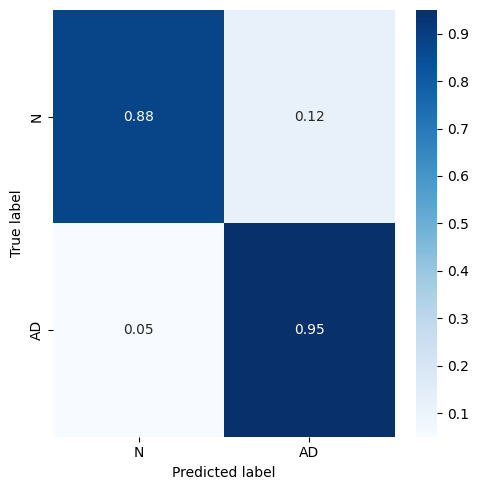

In [13]:
# # create confusion matrix
# if False and __name__ == '__main__':
import pandas as pd
import seaborn
y_pred = np.argmax(model.predict(x_data_test), axis=-1)
con_mat = tf.math.confusion_matrix(labels = y_data_test, predictions = y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis = 1)[:, np.newaxis], decimals = 2)
classes = ['N', 'AD']
con_mat_df = pd.DataFrame(con_mat_norm, index = classes, columns = classes)
figure = plt.figure(figsize = (5, 5))
seaborn.heatmap(con_mat_df, annot = True, cmap = plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig(working_dir + '/confusion_matrix.eps', format='eps')
plt.show()